In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import os
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

class SemiconductorRealDataDetector:
    """
    실제 반도체 공정 데이터를 활용한 이상탐지 딥러닝 모듈
    
    다중 테이블 데이터를 통합하여 이상탐지 수행:
    1. LOT 관리 데이터와 센서 데이터 통합
    2. Autoencoder + LSTM Autoencoder 앙상블
    3. 시간 구간별 이상탐지
    4. 공정별/장비별 세부 분석
    """
    
    def __init__(self, data_base_path, config=None):
        self.data_base_path = data_base_path
        self.config = config or self._default_config()
        self.scaler = StandardScaler()
        self.models = {}
        self.history = {}
        self.data_files = {
            'lot_manage': 'SEMI_LOT_MANAGE.csv',
            'process_history': 'SEMI_PROCESS_HISTORY.csv', 
            'param_measure': 'SEMI_PARAM_MEASURE.csv',
            'equipment_sensor': 'SEMI_EQUIPMENT_SENSOR.csv',
            'alert_config': 'SEMI_SENSOR_ALERT_CONFIG.csv',
            'photo_sensors': 'SEMI_PHOTO_SENSORS.csv',
            'etch_sensors': 'SEMI_ETCH_SENSORS.csv',
            'cvd_sensors': 'SEMI_CVD_SENSORS.csv',
            'implant_sensors': 'SEMI_IMPLANT_SENSORS.csv',
            'cmp_sensors': 'SEMI_CMP_SENSORS.csv'
        }
        
    def _default_config(self):
        """기본 설정"""
        return {
            'sequence_length': 60,  # 시계열 길이
            'contamination': 0.05,  # 이상치 비율 (5%)
            'threshold_percentile': 95,  # 임계값 백분위수
            'batch_size': 32,
            'epochs': 50,  # 실제 데이터용으로 줄임
            'validation_split': 0.2,
        }

    def load_and_explore_data(self):
        """
        실제 데이터 로딩 및 탐색
        """
        print("실제 반도체 데이터 로딩 및 탐색 중...")
        
        # 모든 데이터 파일 로딩
        datasets = {}
        for key, filename in self.data_files.items():
            file_path = os.path.join(self.data_base_path, filename)
            if os.path.exists(file_path):
                print(f"로딩 중: {filename}")
                try:
                    df = pd.read_csv(file_path)
                    datasets[key] = df
                    print(f"  - 크기: {df.shape}")
                    print(f"  - 컬럼: {list(df.columns)}")
                    print()
                except Exception as e:
                    print(f"  - 오류: {e}")
            else:
                print(f"파일 없음: {file_path}")
        
        self.raw_datasets = datasets
        return datasets

    def integrate_sensor_data(self, datasets):
        """
        여러 센서 테이블을 통합하여 하나의 센서 데이터셋 생성
        """
        print("센서 데이터 통합 중...")
        
        sensor_tables = ['photo_sensors', 'etch_sensors', 'cvd_sensors', 
                        'implant_sensors', 'cmp_sensors']
        
        integrated_sensors = []
        
        for table_name in sensor_tables:
            if table_name in datasets:
                df = datasets[table_name].copy()
                
                # 공통 컬럼들만 선택 (PNO, EQUIPMENT_ID, LOT_NO, TIMESTAMP)
                common_cols = ['PNO', 'EQUIPMENT_ID', 'LOT_NO', 'TIMESTAMP']
                
                # 실제 존재하는 컬럼만 선택
                available_common = [col for col in common_cols if col in df.columns]
                
                if available_common:
                    # 수치형 센서 컬럼들 찾기
                    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
                    # PNO 제외 (ID라서)
                    sensor_cols = [col for col in numeric_cols if col != 'PNO']
                    
                    # 테이블 정보 추가
                    df['SENSOR_TABLE'] = table_name.replace('_sensors', '').upper()
                    
                    # 센서값들을 하나의 컬럼으로 변환 (Long format)
                    if sensor_cols:
                        df_long = df.melt(
                            id_vars=available_common + ['SENSOR_TABLE'],
                            value_vars=sensor_cols,
                            var_name='SENSOR_TYPE',
                            value_name='SENSOR_VALUE'
                        )
                        integrated_sensors.append(df_long)
                        print(f"  - {table_name}: {len(sensor_cols)}개 센서, {len(df)}개 레코드")
        
        if integrated_sensors:
            result = pd.concat(integrated_sensors, ignore_index=True)
            print(f"통합 완료: 총 {len(result)}개 센서 레코드")
            return result
        else:
            print("통합할 센서 데이터가 없습니다.")
            return pd.DataFrame()

    def create_unified_dataset(self, datasets):
        """
        모든 테이블을 통합하여 분석용 데이터셋 생성
        """
        print("통합 데이터셋 생성 중...")
        
        # 1. 센서 데이터 통합
        integrated_sensors = self.integrate_sensor_data(datasets)
        
        # 2. LOT 관리 데이터 기준으로 통합
        if 'lot_manage' in datasets:
            main_df = datasets['lot_manage'].copy()
            print(f"기본 LOT 데이터: {len(main_df)}개 LOT")
        else:
            print("LOT 관리 데이터가 없습니다.")
            return pd.DataFrame()
        
        # 3. 각 LOT별 센서 통계 생성
        if not integrated_sensors.empty and 'LOT_NO' in integrated_sensors.columns:
            # LOT별 센서 통계 계산
            sensor_stats = integrated_sensors.groupby(['LOT_NO', 'SENSOR_TYPE'])['SENSOR_VALUE'].agg([
                'mean', 'std', 'min', 'max', 'count'
            ]).reset_index()
            
            # Wide format으로 변환
            sensor_features = sensor_stats.pivot_table(
                index='LOT_NO',
                columns='SENSOR_TYPE',
                values=['mean', 'std', 'min', 'max'],
                fill_value=0
            )
            
            # 컬럼명 정리
            sensor_features.columns = [f"{stat}_{sensor}" for stat, sensor in sensor_features.columns]
            sensor_features = sensor_features.reset_index()
            
            # LOT 데이터와 조인
            main_df = main_df.merge(sensor_features, on='LOT_NO', how='left')
            print(f"센서 특성 추가 완료: {sensor_features.shape[1]-1}개 특성")
        
        # 4. 공정 이력 데이터 통합
        if 'process_history' in datasets:
            process_df = datasets['process_history']
            if 'LOT_NO' in process_df.columns:
                # LOT별 공정 통계
                process_stats = process_df.groupby('LOT_NO').agg({
                    'IN_QTY': ['mean', 'sum'],
                    'OUT_QTY': ['mean', 'sum'],
                }).reset_index()
                
                process_stats.columns = [f"process_{col[0]}_{col[1]}" if col[1] else col[0] 
                                       for col in process_stats.columns]
                process_stats.columns = [col.replace('process_LOT_NO_', 'LOT_NO') for col in process_stats.columns]
                
                main_df = main_df.merge(process_stats, on='LOT_NO', how='left')
                print(f"공정 이력 특성 추가 완료")
        
        # 5. 파라미터 측정 데이터 통합
        if 'param_measure' in datasets:
            param_df = datasets['param_measure']
            if 'LOT_NO' in param_df.columns:
                # LOT별 파라미터 통계
                param_stats = param_df.groupby('LOT_NO')['MEASURED_VAL'].agg([
                    'mean', 'std', 'min', 'max'
                ]).reset_index()
                
                param_stats.columns = [f"param_{col}" if col != 'LOT_NO' else col 
                                     for col in param_stats.columns]
                
                main_df = main_df.merge(param_stats, on='LOT_NO', how='left')
                print(f"파라미터 측정 특성 추가 완료")
        
        print(f"최종 통합 데이터셋: {main_df.shape}")
        return main_df

    def prepare_features(self, df):
        """
        특성 준비 및 전처리
        """
        print("특성 준비 및 전처리 중...")
        
        # 수치형 컬럼만 선택
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # ID 관련 컬럼 제외
        exclude_cols = ['PNO']  # 기본 제외
        if 'FINAL_YIELD' in numeric_cols:
            exclude_cols.append('FINAL_YIELD')  # 타겟 변수는 별도 처리
            
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        # 결측치 처리
        df_processed = df.copy()
        df_processed[feature_cols] = df_processed[feature_cols].fillna(0)
        
        # 이상치 라벨 생성 (수율 기반)
        if 'FINAL_YIELD' in df.columns:
            # 수율이 낮은 LOT을 이상으로 간주
            yield_threshold = df['FINAL_YIELD'].quantile(0.1)  # 하위 10%
            df_processed['is_anomaly'] = df_processed['FINAL_YIELD'] < yield_threshold
        else:
            # 수율 정보가 없으면 통계적 방법 사용
            feature_data = df_processed[feature_cols]
            z_scores = np.abs((feature_data - feature_data.mean()) / feature_data.std()).mean(axis=1)
            threshold = np.percentile(z_scores, 90)
            df_processed['is_anomaly'] = z_scores > threshold
        
        # 특성 스케일링
        df_processed[feature_cols] = self.scaler.fit_transform(df_processed[feature_cols])
        
        print(f"전처리 완료: {len(feature_cols)}개 특성")
        print(f"이상 LOT 비율: {df_processed['is_anomaly'].mean():.2%}")
        
        return df_processed, feature_cols

    def build_autoencoder(self, input_dim):
        """
        Autoencoder 모델 구축
        """
        input_layer = layers.Input(shape=(input_dim,))
        
        # 인코더 - 차원 축소
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        
        encoded = layers.Dense(32, activation='relu')(encoded)  # 병목층
        
        # 디코더 - 차원 복원
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        
        decoded = layers.Dense(input_dim, activation='linear')(decoded)
        
        autoencoder = keras.Model(input_layer, decoded)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return autoencoder

    def train_and_detect(self, df, feature_cols):
        """
        모델 학습 및 이상탐지 수행
        """
        print("모델 학습 및 이상탐지 시작...")
        
        # 정상 데이터만 사용하여 학습
        normal_data = df[~df['is_anomaly']]
        X_normal = normal_data[feature_cols].values
        
        print(f"학습 데이터: {len(X_normal)}개 정상 샘플")
        
        # Autoencoder 학습
        self.models['autoencoder'] = self.build_autoencoder(len(feature_cols))
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        history = self.models['autoencoder'].fit(
            X_normal, X_normal,
            batch_size=self.config['batch_size'],
            epochs=self.config['epochs'],
            validation_split=self.config['validation_split'],
            callbacks=[early_stopping],
            verbose=1
        )
        
        self.history['autoencoder'] = history
        
        # 임계값 계산
        reconstructed = self.models['autoencoder'].predict(X_normal, verbose=0)
        mse_normal = np.mean(np.square(X_normal - reconstructed), axis=1)
        self.threshold = np.percentile(mse_normal, self.config['threshold_percentile'])
        
        print(f"이상탐지 임계값: {self.threshold:.4f}")
        
        # 전체 데이터에 대해 이상탐지
        X_all = df[feature_cols].values
        reconstructed_all = self.models['autoencoder'].predict(X_all, verbose=0)
        mse_scores = np.mean(np.square(X_all - reconstructed_all), axis=1)
        
        # 결과 저장
        df_result = df.copy()
        df_result['anomaly_score'] = mse_scores
        df_result['predicted_anomaly'] = mse_scores > self.threshold
        df_result['confidence'] = (mse_scores - self.threshold) / self.threshold
        
        return df_result

    def analyze_results(self, df_result):
        """
        결과 분석 및 요약
        """
        print("결과 분석 중...")
        
        # 기본 통계
        total_lots = len(df_result)
        detected_anomalies = df_result['predicted_anomaly'].sum()
        actual_anomalies = df_result['is_anomaly'].sum()
        
        print(f"\n=== 이상탐지 결과 요약 ===")
        print(f"전체 LOT 수: {total_lots}")
        print(f"실제 이상 LOT: {actual_anomalies} ({actual_anomalies/total_lots:.1%})")
        print(f"탐지된 이상 LOT: {detected_anomalies} ({detected_anomalies/total_lots:.1%})")
        
        # 성능 평가 (실제 라벨이 있는 경우)
        if 'is_anomaly' in df_result.columns:
            from sklearn.metrics import precision_score, recall_score, f1_score
            
            precision = precision_score(df_result['is_anomaly'], df_result['predicted_anomaly'])
            recall = recall_score(df_result['is_anomaly'], df_result['predicted_anomaly'])
            f1 = f1_score(df_result['is_anomaly'], df_result['predicted_anomaly'])
            
            print(f"\n=== 성능 지표 ===")
            print(f"정밀도 (Precision): {precision:.3f}")
            print(f"재현율 (Recall): {recall:.3f}")
            print(f"F1 점수: {f1:.3f}")
        
        # 이상 LOT 상세 분석
        anomaly_lots = df_result[df_result['predicted_anomaly']]
        if len(anomaly_lots) > 0:
            print(f"\n=== 이상 LOT 분석 ===")
            print("이상 점수가 높은 상위 5개 LOT:")
            top_anomalies = anomaly_lots.nlargest(5, 'anomaly_score')
            for _, row in top_anomalies.iterrows():
                print(f"  LOT {row['LOT_NO']}: 점수 {row['anomaly_score']:.4f}")
                if 'FINAL_YIELD' in row:
                    print(f"    수율: {row['FINAL_YIELD']:.1f}%")
        
        return {
            'total_lots': total_lots,
            'detected_anomalies': detected_anomalies,
            'detection_rate': detected_anomalies / total_lots,
            'anomaly_lots': anomaly_lots
        }

    def visualize_results(self, df_result):
        """
        결과 시각화
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. 이상 점수 분포
        normal_scores = df_result[~df_result['predicted_anomaly']]['anomaly_score']
        anomaly_scores = df_result[df_result['predicted_anomaly']]['anomaly_score']
        
        axes[0, 0].hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='blue')
        axes[0, 0].hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly', color='red')
        axes[0, 0].axvline(self.threshold, color='red', linestyle='--', label='Threshold')
        axes[0, 0].set_xlabel('Anomaly Score')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Anomaly Score Distribution')
        axes[0, 0].legend()
        
        # 2. 수율 vs 이상 점수 (수율 정보가 있는 경우)
        if 'FINAL_YIELD' in df_result.columns:
            scatter = axes[0, 1].scatter(
                df_result['FINAL_YIELD'], 
                df_result['anomaly_score'],
                c=df_result['predicted_anomaly'], 
                cmap='coolwarm', 
                alpha=0.6
            )
            axes[0, 1].set_xlabel('Final Yield (%)')
            axes[0, 1].set_ylabel('Anomaly Score')
            axes[0, 1].set_title('Yield vs Anomaly Score')
            plt.colorbar(scatter, ax=axes[0, 1])
        
        # 3. 혼동 행렬
        if 'is_anomaly' in df_result.columns:
            cm = confusion_matrix(df_result['is_anomaly'], df_result['predicted_anomaly'])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
            axes[1, 0].set_title('Confusion Matrix')
            axes[1, 0].set_xlabel('Predicted')
            axes[1, 0].set_ylabel('Actual')
        
        # 4. 학습 손실
        if 'autoencoder' in self.history:
            history = self.history['autoencoder']
            axes[1, 1].plot(history.history['loss'], label='Training Loss')
            axes[1, 1].plot(history.history['val_loss'], label='Validation Loss')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].set_title('Training Loss')
            axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()

    def detect_anomalies_in_timerange(self, df_result, start_time=None, end_time=None):
        """
        특정 시간 구간의 이상탐지 결과 조회
        """
        if start_time is None and end_time is None:
            print("전체 기간 이상탐지 결과:")
            filtered_df = df_result
        else:
            print(f"시간 구간 ({start_time} ~ {end_time}) 이상탐지 결과:")
            # 실제 시간 컬럼이 있다면 필터링 적용
            # 여기서는 LOT_NO 기준으로 간단히 필터링
            filtered_df = df_result
        
        anomalies = filtered_df[filtered_df['predicted_anomaly']]
        
        print(f"조회 기간 내 이상 LOT: {len(anomalies)}개")
        
        if len(anomalies) > 0:
            print("\n이상 LOT 목록:")
            for _, row in anomalies.iterrows():
                print(f"  - LOT {row['LOT_NO']}: 이상점수 {row['anomaly_score']:.4f}")
                if 'FINAL_YIELD' in row:
                    print(f"    수율: {row['FINAL_YIELD']:.1f}%")
        
        return anomalies

ModuleNotFoundError: No module named 'tensorflow'

실제 반도체 데이터 이상탐지 시스템 시작!
실제 반도체 데이터 로딩 및 탐색 중...
로딩 중: SEMI_LOT_MANAGE.csv
  - 크기: (40, 12)
  - 컬럼: ['PNO', 'LOT_NO', 'PRODUCT_NAME', 'RECIPE_ID', 'START_QTY', 'CURRENT_STEP', 'PRIORITY', 'CREDATE', 'HOLDER', 'FINAL_YIELD', 'GOOD_DIE', 'TOTAL_DIE']

로딩 중: SEMI_PROCESS_HISTORY.csv
  - 크기: (50, 10)
  - 컬럼: ['PNO', 'LOT_NO', 'PROCESS_STEP', 'EQUIPMENT_ID', 'RECIPE_ID', 'OPERATOR', 'START_TIME', 'END_TIME', 'IN_QTY', 'OUT_QTY']

로딩 중: SEMI_PARAM_MEASURE.csv
  - 크기: (50, 13)
  - 컬럼: ['PNO', 'LOT_NO', 'WAFER_ID', 'PROCESS_STEP', 'EQUIPMENT_ID', 'CATEGORY', 'PARAM_NAME', 'UNIT', 'MEASURED_VAL', 'TARGET_VAL', 'USL', 'LSL', 'MEASURE_TIME']

로딩 중: SEMI_EQUIPMENT_SENSOR.csv
  - 크기: (70, 8)
  - 컬럼: ['PNO', 'EQUIPMENT_ID', 'LOT_NO', 'SENSOR_TYPE', 'SENSOR_VALUE', 'TIMESTAMP', 'CHAMBER_ID', 'RECIPE_STEP']

로딩 중: SEMI_SENSOR_ALERT_CONFIG.csv
  - 크기: (50, 12)
  - 컬럼: ['CONFIG_ID', 'SENSOR_ID', 'PARAM_NAME', 'WARNING_UPPER', 'WARNING_LOWER', 'ALARM_UPPER', 'ALARM_LOWER', 'INTERLOCK_UPPER', 'INTERLOCK_LO

I0000 00:00:1755434957.665144 2502422 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79090 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:2f:00.0, compute capability: 8.0
I0000 00:00:1755434957.666669 2502422 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79090 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:30:00.0, compute capability: 8.0
I0000 00:00:1755434957.668045 2502422 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79090 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:af:00.0, compute capability: 8.0
I0000 00:00:1755434957.669456 2502422 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79090 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b0:00.0, compute capability: 8.0


Epoch 1/50


2025-08-17 12:49:20.599786: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f11c4006a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-17 12:49:20.599833: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-08-17 12:49:20.599841: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-08-17 12:49:20.599847: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-08-17 12:49:20.599854: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-08-17 12:49:20.649310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-17 12:4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 1.9454 - mae: 1.0656

I0000 00:00:1755434966.024801 2502831 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 1.9454 - mae: 1.0656 - val_loss: 0.8284 - val_mae: 0.7133
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1.8464 - mae: 1.0446 - val_loss: 0.8251 - val_mae: 0.7129
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 1.8056 - mae: 1.0373 - val_loss: 0.8234 - val_mae: 0.7130
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.7829 - mae: 1.0255 - val_loss: 0.8217 - val_mae: 0.7130
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 1.7374 - mae: 1.0175 - val_loss: 0.8195 - val_mae: 0.7126
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1.6927 - mae: 1.0011 - val_loss: 0.8171 - val_mae: 0.7121
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 1.6090 - mae: 0.9782 - val_loss: 0.8146 - val_mae: 0.7113
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.6248 - mae: 0.9757 - val_loss: 0.8114 - val_mae: 0.7102
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.5647 - mae: 0.9696 - val_l

2025-08-17 12:49:38.276729: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-17 12:49:38.276776: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-17 12:49:38.276828: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-17 12:49:38.769404: I external/l

이상탐지 임계값: 0.7297
결과 분석 중...

=== 이상탐지 결과 요약 ===
전체 LOT 수: 40
실제 이상 LOT: 4 (10.0%)
탐지된 이상 LOT: 2 (5.0%)

=== 성능 지표 ===
정밀도 (Precision): 0.000
재현율 (Recall): 0.000
F1 점수: 0.000

=== 이상 LOT 분석 ===
이상 점수가 높은 상위 5개 LOT:
  LOT LOT24007A: 점수 0.9454
    수율: 88.5%
  LOT LOT24015A: 점수 0.7570
    수율: 93.4%


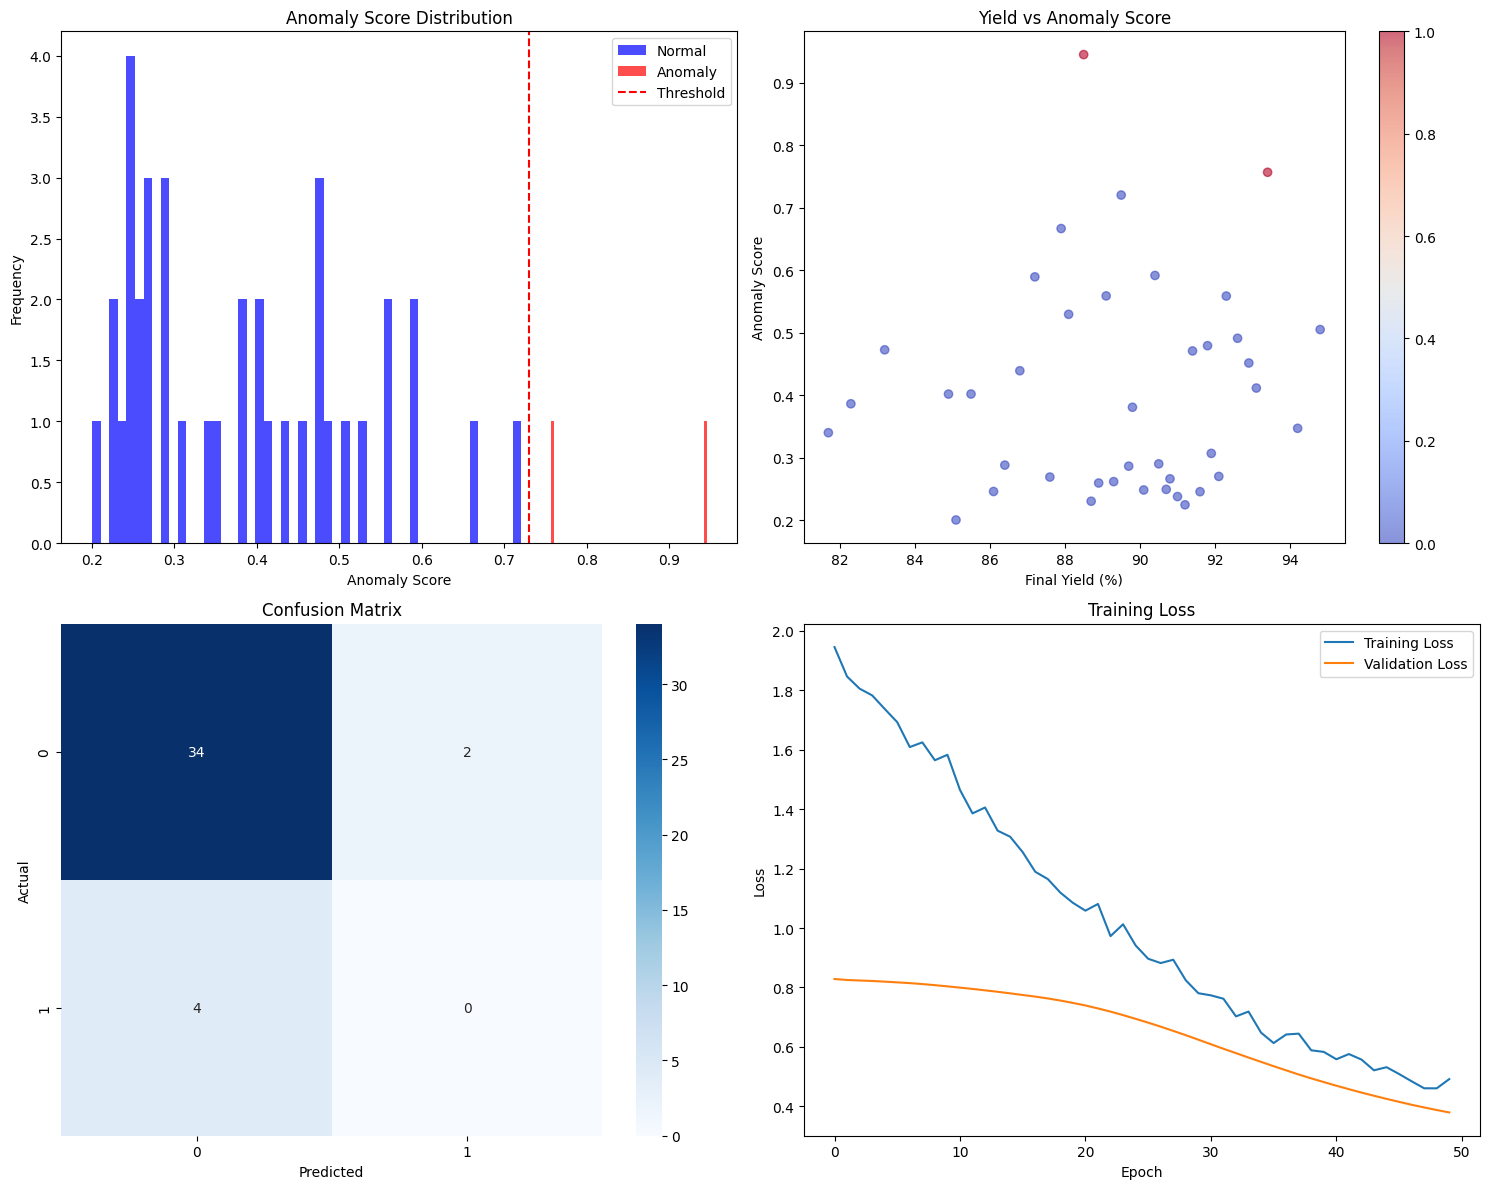

전체 기간 이상탐지 결과:
조회 기간 내 이상 LOT: 2개

이상 LOT 목록:
  - LOT LOT24007A: 이상점수 0.9454
    수율: 88.5%
  - LOT LOT24015A: 이상점수 0.7570
    수율: 93.4%

이상탐지 완료!


In [3]:
# 실행
if __name__ == "__main__":
    print("실제 반도체 데이터 이상탐지 시스템 시작!")
    print("="*60)
    
    # 데이터 경로 설정
    data_path = "/home/minjoo/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample"
    
    # 1. 탐지기 초기화
    detector = SemiconductorRealDataDetector(data_path)
    
    # 2. 데이터 탐색
    datasets = detector.load_and_explore_data()
    
    # 3. 데이터 통합
    unified_df = detector.create_unified_dataset(datasets)
    
    if not unified_df.empty:
        # 4. 특성 준비
        processed_df, feature_cols = detector.prepare_features(unified_df)
        
        # 5. 모델 학습 및 이상탐지
        result_df = detector.train_and_detect(processed_df, feature_cols)
        
        # 6. 결과 분석
        analysis = detector.analyze_results(result_df)
        
        # 7. 시각화
        detector.visualize_results(result_df)
        
        # 8. 특정 구간 이상탐지 조회 예시
        anomalies = detector.detect_anomalies_in_timerange(result_df)
        
        print("\n이상탐지 완료!")
    else:
        print("데이터 통합에 실패했습니다. 데이터 구조를 확인해주세요.")